Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term

X [1.  0.5]
on boundary True
X [ 0.5 -0.5]
on boundary True
X [-0.5  0.5]
on boundary True
X [-0.25 -0.5 ]
on boundary True
X [0.25 0.5 ]
on boundary True
X [ 1.   -0.25]
on boundary True
X [-1.    0.25]
on boundary True
X [-0.625 -0.5  ]
on boundary True
X [0.625 0.5  ]
on boundary True
X [ 0.875 -0.5  ]
on boundary True
X [-0.875  0.5  ]
on boundary True
X [ 0.125 -0.5  ]
on boundary True
X [-0.125  0.5  ]
on boundary True
X [1.    0.125]
on boundary True
X [-1.    -0.125]
on boundary True
X [-0.8125 -0.5   ]
on boundary True
X [0.8125 0.5   ]
on boundary True
X [ 0.6875 -0.5   ]
on boundary True
X [-0.6875  0.5   ]
on boundary True
X [-0.0625 -0.5   ]
on boundary True
X [0.0625 0.5   ]
on boundary True
X [ 1.     -0.0625]
on boundary True
X [-1.      0.0625]
on boundary True
X [-0.4375 -0.5   ]
on boundary True
X [0.4375 0.5   ]
on boundary True
X [ 1.     -0.4375]
on boundary True
X [-1.      0.43

c:\Users\Pablo\AppData\Local\pypoetry\Cache\virtualenvs\deepxde-custom-4PBOT-FI-py3.10\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.501469 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [4.27e-02, 9.77e-03, 2.47e-02, 5.28e-02, 2.47e-02, 8.45e-01, 3.25e-02, 1.60e-02, 3.24e-02]    [3.14e-02, 7.61e-03, 2.64e-02, 5.28e-02, 2.47e-02, 8.45e-01, 3.25e-02, 1.60e-02, 3.24e-02]    []  


KeyboardInterrupt: 

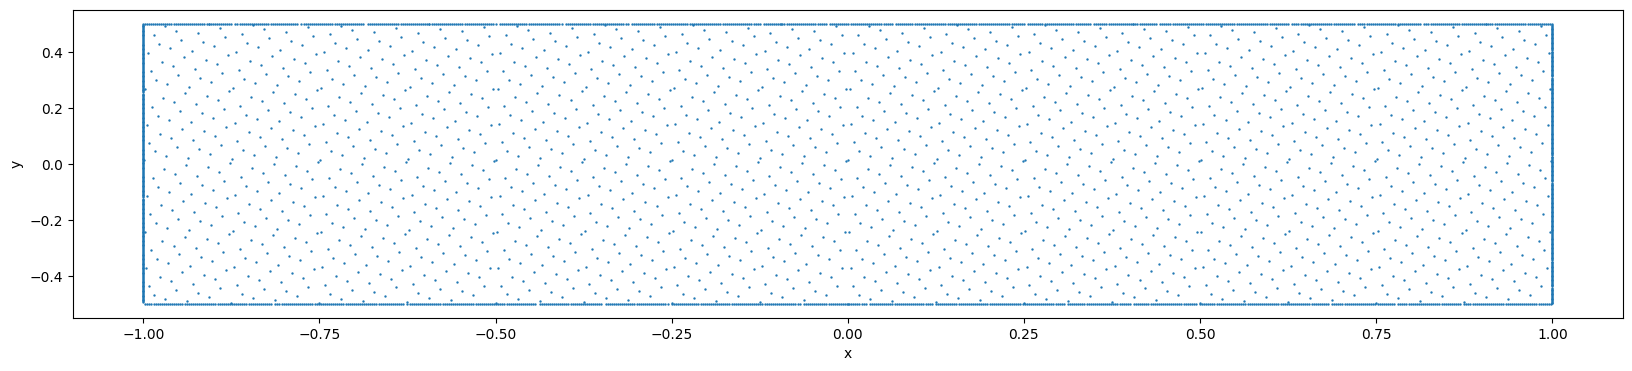

In [1]:
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

rho = 1
mu = 1
u_in = 1
D = 1
L = 2

geom = dde.geometry.Rectangle(xmin=[-L/2,-D/2],xmax=[L/2,D/2])

def boundary_wall(X, on_boundary):
  print("X",X)
  print("on boundary",on_boundary)

  on_wall = np.logical_and(np.logical_or(np.isclose(X[1],-D/2,rtol=1e-05,atol=1e-08),np.isclose(X[1],D/2,rtol=1e-05,atol=1e-08)),on_boundary)
  return on_wall

def boundary_inlet(X,on_boundary):
  on_inlet = np.logical_and(np.isclose(X[0],-L/2,rtol=1e-05,atol=1e-08),on_boundary)
  return on_inlet

def boundary_outlet(X,on_boundary):
  on_outlet = np.logical_and(np.isclose(X[0],L/2,rtol=1e-05,atol=1e-08),on_boundary)
  return on_outlet

bc_wall_u = dde.DirichletBC(geom, lambda X:0., boundary_wall, component =0)
bc_wall_v = dde.DirichletBC(geom, lambda X:0., boundary_wall, component =1)

bc_inlet_u = dde.DirichletBC(geom, lambda X:u_in, boundary_inlet, component =0)
bc_inlet_v = dde.DirichletBC(geom, lambda X:0., boundary_inlet, component =1)

bc_outlat_p = dde.DirichletBC(geom, lambda X:0., boundary_outlet, component =2)
bc_outlat_v = dde.DirichletBC(geom, lambda X:0., boundary_outlet, component =1)

def pde(X,Y):
  du_x =dde.grad.jacobian(Y, X, i=0, j=0)
  du_y =dde.grad.jacobian(Y, X, i=0, j=1)
  dv_x =dde.grad.jacobian(Y, X, i=1, j=0)
  dv_y =dde.grad.jacobian(Y, X, i=1, j=1)
  dp_x =dde.grad.jacobian(Y, X, i=2, j=0)
  dp_y =dde.grad.jacobian(Y, X, i=2, j=1)
  du_xx = dde.grad.hessian(Y, X, component=0, i=0, j=0)
  du_yy = dde.grad.hessian(Y, X, component=0, i=1, j=1)
  dv_xx = dde.grad.hessian(Y, X, component=1, i=0, j=0)
  dv_yy = dde.grad.hessian(Y, X, component=1, i=1, j=1)

  pde_u    = Y[:,0:1]*du_x +  Y[:,1:2]*du_y + 1/rho * dp_x - (mu/rho) * (du_xx+ du_yy)
  pde_v    = Y[:,0:1]*dv_x +  Y[:,1:2]*dv_y + 1/rho * dp_y - (mu/rho) * (dv_xx+ dv_yy)
  pde_cont = du_x + dv_y

  return [pde_u,pde_v,pde_cont]

data = dde.data.PDE(geom,
                    pde,
                    [bc_wall_u,bc_wall_v,bc_inlet_u,bc_inlet_v,bc_outlat_p,bc_outlat_v],
                    num_domain = 2000,
                    num_boundary = 2000,
                    num_test = 200)

plt.figure(figsize=(20,4))
plt.scatter(data.train_x_all[:,0],data.train_x_all[:,1],s=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.show

net = dde.maps.FNN([2]+[64]*5+[3], "tanh","Glorot uniform")

model = dde.Model(data,net)
model.compile("adam",lr=1e-3)

losshistory,train_state = model.train(epochs = 10000)

dde.optimizers.config.set_LBFGS_options(maxiter = 30)
model.compile("L-BFGS")
losshistory,train_state = model.train()
dde.saveplot(losshistory, train_state, issave = False , isplot = False)

samples= geom.random_points(500000)
result = model.predict(samples)

color_legend=[[0,1.5],[-0.3,0.3],[0,35]]
for idx in range(3):
  plt.figure(figsize=(20,4))
  plt.scatter(samples[:,0], samples[:,1], c=result[:,idx], cmap='viridis',s=2)
  plt.colorbar()
  plt.clim(color_legend[idx])
  plt.xlim((0-D/2,D-D/2))
  plt.xlim((0-L/2,L-L/2))
  plt.tight_layout()
  plt.show()